In [ ]:
#FIRST ACTIVATE r-with-gdal ENVIRONMENT

This code is adapted from Amber Liang for use on the MAAP to match Protected and Non Protected areas

In [ ]:
#For optmatch, paste into terminal:
#First time only, run this first:
#wget -O optmatch_0.10.6.tar.gz https://packagemanager.posit.co/cran/__linux__/bullseye/latest/src/contrib/optmatch_0.10.6.tar.gz?r_version=4.3&arch=x86_64

#R CMD INSTALL optmatch_0.10.6.tar.gz


In [1]:
#IN TERMINAL:
#mamba install -c conda-forge r-rlemon r-svd r-sparsem r-survival r-RItools r-geojsonio
install.packages('RItools')
install.packages("spatialEco", version='1.3.2')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library("devtools")
library('RItools')
library("sfheaders")
library("spatialEco")

Loading required package: usethis

Loading required package: ggplot2

Warning message:
“package ‘sfheaders’ was built under R version 4.3.2”


In [3]:
#Use mamba install -c conda-forge r-____ to install packages
#mamba install -c conda-forge r-terra r-optmatch r-sp r-rgdal r-sf r-rgeos r-dplyr r-plyr r-ggplot2 r-raster r-mapview r-stringr r-maptools r-gridExtra r-lattice r-MASS r-foreach r-doParallel r-rlang r-tidyr r-magrittr r-viridis r-ggmap r-Hmisc r-hrbrthemes r-spatialEco r-bit64 r-randomForest r-modelr

#!/usr/bin/env Rscript

# This global processing script is derived from the global processing notebook 
#the input can be the iso3 code (3-character) for one or multiple countries 

options(warn=-1)
options(dplyr.summarise.inform = FALSE)

packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr","terra",
              "maptools","gridExtra","lattice","MASS","foreach","doParallel","RItools","optmatch",
              "rlang","tidyr","magrittr","viridis","ggmap","Hmisc","hrbrthemes","spatialEco","bit64","randomForest", "modelr")
#as.factor(paste0('r-', packages," "))



package.check <- lapply(packages, FUN = function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
})


In [4]:
#To test, we define the variables manually. For final version, run the commented out section below
gediwk <- 24
iso3 <-"SEN"
mproc <- 1
# args = commandArgs(trailingOnly=TRUE)
# if (length(args)==0) {
#   stop("At least one argument must be supplied (input file).n", call.=FALSE)
# } else if (length(args)>=1) {
  
#   iso3 <- args[1]  #country to process
#   gediwk <- args[2]   #the # of weeks GEDI data to use
#   mproc <- as.integer(args[3])#the number of cores to use for macthing 
# }

In [5]:
cat("Step 0: Loading global variables for", iso3,"with wk", gediwk, "data \n")

Step 0: Loading global variables for SEN with wk 24 data 


In [6]:
#f.path<-"https://maap-ops-workspace.s3.amazonaws.com/shared/abarenblitt/GEDI_PA/Matching_Layers/SEN/"

f.path <- "~/GEDI_PA/Matching_Layers/SEN/"
matching_tifs <- c("wwf_ecoreg","wwf_biomes","d2roads", "dcities","dem","pop_cnt_2000","pop_den_2000","slope", "tt2cities_2000", "wc_prec_1990-1999",
                   "lc2000","wc_tmax_1990-1999","wc_tavg_1990-1999","wc_tmin_1990-1999" )

In [7]:
list.files(path=f.path, pattern=NULL, all.files=FALSE, 
    full.names=FALSE)

[1] "24.RDS"                       "annual_mean_temp.tif"        
 [3] "annual_prec.tif"              "biomes.tif"                  
 [5] "d2roads.tif"                  "dcities.tif"                 
 [7] "dem.tif"                      "ecoreg.tif"                  
 [9] "glad2000.tif"                 "lc2000.tif"                  
[11] "lc2019.tif"                   "mean_gHM.tif"                
[13] "NA.RDS"                       "pop_cnt_2000.tif"            
[15] "pop_cnt_2020.tif"             "pop_den_2000.tif"            
[17] "pop_den_2020.tif"             "SEN_admin_L4A.gpkg"          
[19] "SEN_admin.geojson"            "SEN_PA_poly.rds"             
[21] "slope.tif"                    "tt2cities_2000.tif"          
[23] "tt2cities_2015.tif"           "tt2cities.tif"               
[25] "wc_prec_1990-1999.tif"        "wc_prec_2010-2018.tif"       
[27] "wc_tavg_1990-1999.tif"        "wc_tavg_2010-2018.tif"       
[29] "wc_tmax_1990-1999.tif"        "wc_tmax_2010-2018.tif"       
[31] "wc_tmin_1990-1999.tif"        "wc_tmin_2010-2018.tif"       
[33] "WDPA_gedi_l2a+l2b_clean2_SEN" "WDPA_matching_log"           
[35] "WDPA_matching_points"         "wwf_biomes.tif"              
[37] "wwf_ecoreg.tif"               "wwf_realms.tif"

In [8]:
#allPAs will need to come from Celio once we have full IUCN list, follow format of Amber's example rds file

ecoreg_key <- read.csv(paste("~/GEDI_PA/wwf_ecoregions_key.csv",sep=""))
allPAs <- readRDS(paste("~/GEDI_PA/SEN_PA_poly.rds",sep=""))
MCD12Q1 <- raster(paste("~/GEDI_PA/","GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep=""))
projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
world_region <- raster(paste("~/GEDI_PA/","GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep=""))
projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
adm <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_admin.geojson"),verbose=F)
adm_prj <- spTransform(adm, "+init=epsg:6933") 
load("~/GEDI_PA/rf_noclimate.rdata")
source("~/GEDI_PA/matching_func.r")

In [9]:
gedi_folder <- paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN")
list.files(path=gedi_folder, pattern=NULL, all.files=FALSE, 
    full.names=FALSE)
gedi_data <- readOGR(list.files(gedi_folder,full.names=TRUE))
#gedi_data <- readOGR(list.files(gedi_folder,full.names=TRUE)[i], "SEN_admin_L2A")

[1] "SEN_admin_L2A.gpkg"

OGR data source with driver: GPKG 
Source: "/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg", layer: "SEN_admin_L2A"
with 12774217 features
It has 10 fields
Integer64 fields read as strings:  shot_number 


In [237]:
# STEP1. Create 1km sampling grid with points only where GEDI data is available; first check if grid file exist to avoid reprocessing 
if(!file.exists(paste("~/GEDI_PA/Matching_Layers/SEN/*.rds"))){
  cat("Step 1: Creating 1km sampling grid filter GEDI data for", iso3,"\n")
  GRID.lats <- raster("~/GEDI_PA/EASE2_M01km_lats.tiff")
  GRID.lons <- raster("~/GEDI_PA/EASE2_M01km_lons.tiff")
  GRID.lats.adm   <- crop(GRID.lats, adm_prj)
  GRID.lats.adm.m <- raster::mask(GRID.lats.adm, adm_prj)
  GRID.lons.adm   <- crop(GRID.lons, adm_prj)
  GRID.lons.adm.m <- raster::mask(GRID.lons.adm, adm_prj)
  rm(GRID.lats, GRID.lons, GRID.lats.adm, GRID.lons.adm)
  
  #1.3) extract coordinates of raster cells with valid GEDI data in them
  gedi_folder <- paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN")
  
  GRID.coords <- data.frame()
  for(i in 1:length(dir(gedi_folder))){
    # print(list.files(gedi_folder)[i])
    gedi_data <- read_sf(list.files(gedi_folder,full.names=TRUE)[i]) %>%
      dplyr::select(lon_lowestmode,lat_lowestmode)
    gedi_data<- gedi_data %>% st_drop_geometry()
    gedi_pts  <- SpatialPoints(coords=gedi_data[,c("lon_lowestmode","lat_lowestmode")],
                               proj4string=CRS("+init=epsg:4326"))
    gedi_pts_prj <- spTransform(gedi_pts, "+init=epsg:6933")
    
    gcount_ras <- rasterize(coordinates(gedi_pts_prj),GRID.lons.adm.m , fun="count",background=NA)
    names(gcount_ras) <- "gshot_counts"
    pxid <- raster::extract(gcount_ras,  gedi_pts_prj)
    gedi_pts_prj %>% 
      SpatialPointsDataFrame(., data=data.frame(pxid)) ->gedi_pts_prj_sp
    gedi_pts_prj_sp$pxid[is.na(gedi_pts_prj_sp$pxid)] <- 0
    gedi_pts_prj_sp[gedi_pts_prj_sp$pxid>5,]->gedi_pts_prj_filtered  #change the numeric threshold to filter with a different min # of GEDI shots in each 1km cell
    
    GRID.lons.overlap <- GRID.lons.adm.m[gedi_pts_prj_filtered]
    GRID.lats.overlap <- GRID.lats.adm.m[gedi_pts_prj_filtered]
    
    x.overlap <- GRID.lons.overlap[!is.na(GRID.lons.overlap)]
    y.overlap <- GRID.lats.overlap[!is.na(GRID.lats.overlap)]
    
    xy.overlap <- cbind(x.overlap,y.overlap)
    xy.overlap.clean <- unique(xy.overlap)
    
    GRID.coords <- rbind(GRID.coords, xy.overlap.clean) 
  }
  GRID.for.matching <- SpatialPoints(coords = GRID.coords, proj4string=CRS("+init=epsg:4326"))
  saveRDS(GRID.for.matching, file = paste("~/GEDI_PA/Matching_Layers/SEN/",gediwk,".RDS", sep=""))
} else if (file.exists(paste("~/GEDI_PA/Matching_Layers/SEN/",gediwk,".RDS", sep=""))) {
  cat(paste("STEP 1: Grid file exists, no need to process grids for ",iso3, "\n"))
}

Step 1: Creating 1km sampling grid filter GEDI data for SEN 
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character


In [239]:
library("geojsonio")
df <- readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/24.RDS")
head(df)

SpatialPoints:
     x.overlap y.overlap
[1,] -16.16701  12.45614
Coordinate Reference System (CRS) arguments: +proj=longlat +datum=WGS84
+no_defs 

In [240]:
# STEP2. Clip sampling grid to nonPA areas within country & sample raster layers on nonPA grid
cat("Step 2.0: Reading 1k GRID from RDS for " ,iso3, "\n")
GRID.for.matching <- df

#GRID.for.matching2 <- as(GRID.for.matching,'Spatial')
print(GRID.for.matching)
#GRID.pts.nonPA <- GRID.for.matching2 %>% spTransform(.,"+init=epsg:4326")

#head(GRID.pts.nonPA)


Step 2.0: Reading 1k GRID from RDS for  SEN 
class       : SpatialPoints 
features    : 188123 
extent      : -17.52593, -11.35373, 12.31164, 16.68501  (xmin, xmax, ymin, ymax)
crs         : +proj=longlat +datum=WGS84 +no_defs 


In [243]:
if(file.exists(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/24.RDS"))){
  cat("Step 2.1: Preparing control dataset for", iso3, "\n")
  GRID.pts.nonPA <-GRID.for.matching %>% spTransform(., "+init=epsg:4326")
    for(i in 1:length(allPAs)){
  #print(allPAs)
  # print(i)
      PA          <- allPAs[i,]
      PA_prj      <- spTransform(PA, "+init=epsg:6933")
      PA_prj_buff <- gBuffer(PA_prj, width = 10000) #10km buffer
      PA2         <- spTransform(PA_prj_buff, "+init=epsg:4326")
  # GRID.pts.nonPA <- GRID.pts.nonPA %>% SpatialPoints(.)
  # print(class(PA2))
  # print(class(GRID.pts.nonPA))
  # print(length(GRID.pts.nonPA))
  
      overlap     <- GRID.pts.nonPA[PA2]
        if(length(overlap)>0){
            GRID.pts.nonPA0 <- st_difference(sf::st_as_sf(GRID.pts.nonPA), sf::st_as_sf(PA2)) ##remove pts inside poly
            GRID.pts.nonPA <- as(GRID.pts.nonPA0$geometry,'Spatial') %>% spTransform(., "+init=epsg:4326")
      }
    }

  nonPA_xy  <- coordinates(GRID.pts.nonPA)
  colnames(nonPA_xy)  <- c("x","y")
  nonPA_spdf  <- tryCatch(SpatialPointsDataFrame(nonPA_xy, data=data.frame(nonPA_xy),
                                        proj4string=CRS("+init=epsg:4326")),
                          error=function(cond){
                            cat("Country too small, after buffer no grid left, so quit processing country", iso3, dim(nonPA_xy),"\n")
                            writeLines("Country too small, after buffer no grid left", paste("~/GEDI_PA/Matching_Layers/SEN/","WDPA_log/",iso3,"_log_control.txt", sep=""))
                            return(quit(save="no"))})

    
  for (j in 1:length(matching_tifs)){
     # print(matching_tifs[j])
    ras <- raster(paste("~/GEDI_PA/Matching_Layers/SEN/",matching_tifs[j],".tif", sep=""))
    ras_ex <- raster::extract(ras, nonPA_spdf@coords, method="simple", factors=FALSE)
    nm <- names(ras)
    nonPA_spdf <- cbind(nonPA_spdf, ras_ex)
    # print(nonPA_spdf)
    names(nonPA_spdf)[j+2] <- matching_tifs[j]
    
  }
  d_control <- nonPA_spdf
  d_control$status <- as.logical("FALSE")
  names(d_control) <- make.names(names(d_control), allow_ = FALSE)
  d_control <- data.frame(d_control) %>%
    dplyr::rename(
      land_cover = lc2000,
      slope = slope,
      elevation = dem,
      popden = pop.den.2000,
      popcnt=pop.cnt.2000,
      min_temp=wc.tmin.1990.1999,
      max_temp=wc.tmax.1990.1999,
      mean_temp = wc.tavg.1990.1999,
      prec = wc.prec.1990.1999,
      tt2city= tt2cities.2000,
      wwfbiom = wwf.biomes,
      wwfecoreg = wwf.ecoreg,
      d2city = dcities,
      d2road = d2roads,
      lon = x,
      lat = y)
 d_control$land_cover <- factor(d_control$land_cover, levels=sequence(7),
                                 labels = c("l1_forest",
                                            "l2_grassland",
                                            "l3_agriculture",
                                            "l4_wetlands",
                                            "l5_artificial",
                                            "l6_other land/bare",
                                            "l7_water"))
  d_control$wwfbiom <- factor(d_control$wwfbiom,
                           levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                           labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
  d_control$wwfecoreg <- factor(d_control$wwfecoreg,
                             levels = as.vector(ecoreg_key[,"ECO_ID"]),
                             labels = as.vector(ecoreg_key[,"ECO_NAME"]))
  
  
  d_control$UID <-  seq.int(nrow(d_control))
    
    
    
  
  saveRDS(d_control, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_prepped_control_wk.RDS",sep="")) 
  
} else if (file.exists(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_prepped_control_wk.RDS",sep=""))){
  cat("Step 2.1: preppred control dataset is already exist for", iso3, "no need for reprocessing\n")
}

Step 2.1: Preparing control dataset for SEN 


In [244]:
cat("Step 3.0: Reading 1k GRID from RDS for " ,iso3)

Step 3.0: Reading 1k GRID from RDS for  SEN

In [245]:
df <- readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_prepped_control_wk.RDS")
head(df)

,lon,lat,wwfecoreg,wwfbiom,d2road,d2city,elevation,popcnt,popden,slope,⋯,prec,land_cover,max_temp,mean_temp,min_temp,status,x.1,y.1,optional,UID
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<int>
1,-16.16701,12.45614,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.03333332,0.8013874,25,118.8777,141.4693,0.5615034,⋯,4412.922,l3_agriculture,35.95318,26.28786,15.43029,FALSE,-16.16701,12.45614,TRUE,1
2,-16.16701,12.46417,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.04166665,0.8073015,19,133.2313,158.5557,0.4001583,⋯,4310.026,l1_forest,35.98138,26.31813,15.44190,FALSE,-16.16701,12.46417,TRUE,2
3,-16.17739,12.46417,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.03726779,0.8131725,25,133.2312,158.5557,0.5752334,⋯,4311.596,l1_forest,35.97405,26.32152,15.44966,FALSE,-16.17739,12.46417,TRUE,3
4,-16.17739,12.47220,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.03333332,0.8190863,27,133.2270,158.5557,0.5554368,⋯,4299.956,l1_forest,35.97803,26.32592,15.45192,FALSE,-16.17739,12.47220,TRUE,4
5,-16.17739,12.48023,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.02499999,0.8249576,26,133.2227,158.5557,0.3898394,⋯,4299.956,l1_forest,35.97803,26.32592,15.45192,FALSE,-16.17739,12.48023,TRUE,5
6,-16.18776,12.48023,Guinean forest-savanna mosaic,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.02635230,0.8308710,19,133.2227,158.5557,0.3166382,⋯,4299.956,l1_forest,35.97803,26.32592,15.45192,FALSE,-16.18776,12.48023,TRUE,6


In [301]:
#STEP3. Loop through all PAs in iso3 country:
# - clip sampling grid to each PA
# - sample raster layers on each PA grid
# - save each PA sample into prepped_pa_##.RDS file

cat("Step 3.0: Reading 1k GRID from RDS for " ,iso3)
GRID.for.matching <- readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/24.RDS")

if(length(dir(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_testPAs",sep=""),pattern = paste(gediwk,".RDS",sep="")))==0){
  cat("Step 3.1: Processing prepped PA treatment dataset for ", iso3, "\n")
  for(i in 1:length(allPAs)){
    cat(iso3, i, "out of ", length(allPAs), "\n")
    testPA <- allPAs[i,]
    testPA <- spTransform(testPA, "+init=epsg:4326")
    GRID.pts.testPA <- GRID.for.matching[testPA]
    
    if(length(GRID.pts.testPA)>0){
      testPA_xy <- coordinates(GRID.pts.testPA)
      colnames(testPA_xy) <- c("x","y")
      testPA_spdf <- SpatialPointsDataFrame(testPA_xy, data=data.frame(testPA_xy),
                                            proj4string=CRS("+init=epsg:4326"))
      for (j in 1:length(matching_tifs)){
        ras <- raster(paste("~/GEDI_PA/Matching_Layers/SEN/",matching_tifs[j],".tif", sep=""))
        ras <- crop(ras, testPA)
        ras_ex <- raster::extract(ras, testPA_spdf@coords, method="simple", factors=F)
        nm <- names(ras)
        testPA_spdf <- cbind(testPA_spdf, ras_ex)
        names(testPA_spdf)[j+2] <- matching_tifs[j]
        
      }
      d_pa <- testPA_spdf
      d_pa$status <- as.logical("TRUE")
      d_pa$DESIG_ENG <- testPA$DESIG_ENG
      d_pa$REP_AREA <- testPA$REP_AREA
      d_pa$PA_STATUS <- testPA$STATUS
      d_pa$PA_STATUSYR <- testPA$STATUS_YR
      d_pa$GOV_TYPE <- testPA$GOV_TYPE
      d_pa$OWN_TYPE <- testPA$OWN_TYPE
      d_pa$MANG_AUTH <- testPA$MANG_AUTH
      names(d_pa) <- make.names(names(d_pa), allow_ = FALSE)
      d_pa <- data.frame(d_pa) %>%
        dplyr::rename(
          land_cover = lc2000,
          slope = slope,
          elevation = dem,
          popden = pop.den.2000,
          popcnt=pop.cnt.2000,
          min_temp=wc.tmin.1990.1999,
          max_temp=wc.tmax.1990.1999,
          mean_temp = wc.tavg.1990.1999,
          prec = wc.prec.1990.1999,
          tt2city= tt2cities.2000,
          wwfbiom = wwf.biomes,
          wwfecoreg = wwf.ecoreg,
          d2city = dcities,
          d2road = d2roads,
          lon = x,
          lat = y)
      d_pa$land_cover <- factor(d_pa$land_cover, levels=sequence(7),
                                labels = c("l1_forest",
                                           "l2_grassland",
                                           "l3_agriculture",
                                           "l4_wetlands",
                                           "l5_artificial",
                                           "l6_other land/bare",
                                           "l7_water"))
      d_pa$wwfbiom <- factor(d_pa$wwfbiom,
                          levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                          labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
      d_pa$wwfecoreg <- factor(d_pa$wwfecoreg,
                            levels = as.vector(ecoreg_key[,"ECO_ID"]),
                            labels = as.vector(ecoreg_key[,"ECO_NAME"]))
      
      d_pa$UID <- seq.int(nrow(d_pa))
      saveRDS(d_pa, file = paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/","prepped_pa_",
                                 testPA$WDPAID,"_wk",gediwk,".RDS", sep="")) 
    }
  }
} else if (length(dir(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_testPAs","/",sep=""),pattern = paste(gediwk,".RDS",sep="")))>0){
  cat("Step 3.1: prepped PA treatment dataset is already exist for ", iso3, "no need for reprocessing\n")
}


Step 3.0: Reading 1k GRID from RDS for  SENStep 3.1: prepped PA treatment dataset is already exist for  SEN no need for reprocessing


In [300]:
readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_testPAs/prepped_pa_2332_wk24.RDS")[1,]

,lon,lat,wwfecoreg,wwfbiom,d2road,d2city,elevation,popcnt,popden,slope,⋯,REP.AREA,PA.STATUS,PA.STATUSYR,GOV.TYPE,OWN.TYPE,MANG.AUTH,x.1,y.1,optional,UID
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<int>
1,-13.9056,14.46352,West Sudanian savanna,"Tropical & Subtropical Grasslands, Savannas & Shrublands",0.1193151,0.7276291,56,2.005423,2.40664,0.03864545,⋯,6337,Designated,1972,Federal or national ministry or agency,State,Not Reported,-13.9056,14.46352,TRUE,1


In [308]:
#STEP4. Set up spatial points data frames (control + each PA) for point matching
# if (file.exists(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,"/",iso3,"_matching_output_wk",gediwk,".RDS", sep=""))){
cat("Step 4: Performing matching for", iso3,"\n")
d_control_local <- readRDS(file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_prepped_control_wk.RDS", sep=""))
d_control_local <-d_control_local[complete.cases(d_control_local), ]  #filter away non-complete cases w/ NA in control set

Step 4: Performing matching for SEN 


In [32]:
if(!dir.exists(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",sep=""))){
  # cat("Matching result dir does not EXISTS\n")
  dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",sep="")))
  d_PAs <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_testPAs/", sep=""), pattern=paste("wk",gediwk,sep=""), full.names=FALSE)
} else if (dir.exists(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",sep=""))){   #if matching result folder exists, check for any PAs w/o matched results
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  matched_PAid <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",sep=""), full.names = FALSE, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  d_PAs<- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_testPAs/", sep=""), pattern=paste("wk",gediwk,sep=""), full.names=FALSE)
  d_PA_id <- d_PAs %>% readr::parse_number()
  runPA_id1 <- d_PA_id[!(d_PA_id %in% matched_PAid)]
  
  matched_all <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
  registerDoParallel(3)
  matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {   #non-NA matched results
    matched_PAs=c()
    # print(this_rds)
    if(nchar(iso3)>3){
      id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
    } else {
      id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
    }
    matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
    if(!is.null(matched)){
      if(nrow(matched)!=0){
        matched_PAs=c(matched_PAs,this_rds) 
      }
    }else {
      # print(this_rds)
      matched_PAs=matched_PAs
    }
    return(matched_PAs)
  }
  stopImplicitCluster()
  
  if(!is.null(matched_PAs)){
    fullmatch_ids <- matched_PAs %>% readr::parse_number()
    runPA_id2 <- d_PA_id[!(d_PA_id %in% fullmatch_ids)]
    runPA_id <- c(runPA_id1,runPA_id2)
    
  } else{
    fullmatch_ids <- d_PAs %>% readr::parse_number()
    runPA_id2 <- fullmatch_ids#d_PA_id[!(d_PA_id %in% fullmatch_ids)]
    runPA_id <- c(runPA_id1,runPA_id2)
    
  }
  
  if (length(runPA_id)>0){
    # Pattern2 <-  paste(runPA_id, collapse="|")
    t <- d_PA_id %in% runPA_id
    runPA <-  d_PAs[t]
    d_PAs <- runPA
  } else {
    d_PAs <- NULL
  }
  write.csv(d_PAs, paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep=""))
  cat("Step 4: need to rerun ", length(d_PAs),"PAs\n")
}

Step 4: need to rerun  3 PAs


In [ ]:
registerDoParallel(mproc)
# cat("Parallel processing",getDoParWorkers(),"PAs \n")
startTime <- Sys.time()
foreach(this_pa=d_PAs,.combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','optmatch','doParallel')) %dopar% {
  pa <- this_pa
  id_pa <-pa %>%str_split("_") %>% unlist %>% .[3]
  # cat(id_pa, "in",iso3,"\n")
  cat("No.", match(pa,d_PAs),"of total",length(d_PAs),"PAs in ", iso3, "\n" )
  d_pa <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_testPAs/",pa, sep=""))
  d_filtered_prop <- tryCatch(propensity_filter(d_pa, d_control_local), error=function(e) return(NA))  #return a df of control and treatment after complete cases and propensity filters are applied
  # cat("Propensity score filtered DF dimension is",dim(d_filtered_prop),"\n")
  d_wocat_all <- tryCatch(filter(d_filtered_prop, status),error=function(e) return(NA))
  d_control_all <- tryCatch(filter(d_filtered_prop, !status),error=function(e) return(NA))
  
  n_control <- dim(d_control_all)[1]
  # ids_all <- d_control_all$UID   #seq(1,n_control)
  ids_all0 <- tryCatch(d_control_all$UID, error=function(e) return(NA))
  ids_all <- d_control_all$UID
  set.seed(125)
  # cat("Using number of cores:",getDoParWorkers(),"\n")
  N <- ceiling(nrow(d_wocat_all)/300)
  l <- tryCatch(split(d_wocat_all, sample(1:N, nrow(d_wocat_all), replace=TRUE)),error=function(e) return(NULL))
  # l <- tryCatch(split(d_wocat_all, (as.numeric(rownames(d_wocat_all))-1) %/% 300),error=function(e) return(0))
  
  if (length(l)<900 && length(l)>0 ){
    pa_match <- data.frame()
    for (pa_c in 1:length(l)){
      ids_all <- d_control_all$UID
      cat("chunk",pa_c,"out of ",length(l), "chunks of PA", id_pa,"\n")
      
      d_wocat_chunk <- l[[pa_c]]
      # #sample the control dataset to the size of the sample dataset, keep unsampled ids to iterate until full number of matches found
      n_treatment <- dim(d_wocat_chunk)[1]
      
      t <- ifelse(floor(n_control/n_treatment)<=7, ifelse(floor(n_control/n_treatment)<1, 1,floor(n_control/n_treatment)),7)   #floor(n_control/n_treatment))
      n_sample <- round(n_treatment*t)    #now the n_control is 1.4 times the number of n_treatment, 7 will set the if ststament below to flase
      m_all2_out <- data.frame()
      Bscore <- data.frame()
      n_matches <- 0
      tryCatch(
        while(n_matches < n_treatment){
          n_ids <- length(ids_all)
          # cat("n ids",n_ids,"\n")
          if(n_ids > n_sample){
            set.seed(125)
            sample_ids_bar <- sample(ids_all, n_sample)
            sample_ids <- sample(ids_all0, n_sample)
            d_control_sample <- d_control_all[d_control_all$UID %in% sample_ids,]
            ids_all <-setdiff(ids_all, sample_ids_bar)    #ids_all[-sample_ids]
            # cat("protected uid", head(d_wocat_chunk$UID),"\n")
            # All approaches
            new_d <- tryCatch(rbind(d_wocat_chunk,d_control_sample),error=function(e) return(NULL))
            # new_d <- tryCatch(rbind(d_wocat_chunk,d_control_all),error=function(e) return(NULL))
            #create a smaller distance matrix
            m_all <- tryCatch(match_wocat(new_d, pid=id_pa),error=function(e) return(NULL))
            # m_all <- match_wocat(new_d)
            m_all2 <- tryCatch(m_all[1,],error=function(e) return(NULL))
            # m_all2 <- m_all[1,]
            n_matches_temp <- tryCatch(nrow(m_all2$df),error=function(e) return(NULL))
            # n_matches_temp <- nrow(m_all2$df)
            if(!is.null(n_matches_temp)){
              # n_matches <- n_matches + nrow(m_all2$df)
              m_all2$df$pa_id <- rep(id_pa,n_matches_temp)
              m_all2_out <- rbind(m_all2_out, m_all2$df)
              matched_protected <- m_all2$df %>% dplyr::filter(status==TRUE)
              matched_control <- m_all2$df %>% dplyr::filter(status==FALSE)
              cat("matched_protected", nrow(matched_protected),"\n")
              n_matches <- n_matches + nrow(matched_protected)
              d_wocat_chunk <- d_wocat_chunk[-(match(matched_protected$UID,d_wocat_chunk$UID)),]
              # d_control_all <- d_control_all[-(match(matched_control$UID,d_control$UID)),]
            } 
            # ids_all <-setdiff(ids_all, sample_ids)
            ids_all0 <-setdiff(ids_all0, matched_control$UID)
            # else {
            #   n_treatment <- 0  #if not macthes are found in this sampling
            # }
          } else {n_treatment <- n_matches}
        }, error=function(e) return(NULL))
      # ids_all0 <-setdiff(ids_all0, matched_control$UID)
      match_score <- m_all2_out
      cat(table(match_score$status),"\n")
      pa_match <- rbind(pa_match,match_score)
    }
  } else if (length(l)>=900){
    registerDoParallel(4)
    pa_match <- foreach(pa_c=1:length(l), .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','optmatch','doParallel'))%dopar%{
      # cat("Matching treatment chunk", pa_c, "out of", length(l), "for PA", id_pa,"\n")
      cat("chunk",pa_c,"out of ",length(l), "chunks of PA", id_pa,"\n")
      # cat("head control",head(ids_all0),"\n")
      d_wocat_chunk <- l[[pa_c]]
      # #sample the control dataset to the size of the sample dataset, keep unsampled ids to iterate until full number of matches found
      n_treatment <- dim(d_wocat_chunk)[1]
      # cat( "n control", length(ids_all0),"\n")
      t <- ifelse(floor(n_control/n_treatment)<=7, ifelse(floor(n_control/n_treatment)<1, 1,floor(n_control/n_treatment)),7)   #floor(n_control/n_treatment))
      n_sample <- round(n_treatment*t)    #now the n_control is 1.4 times the number of n_treatment, 7 will set the if ststament below to flase
      m_all2_out <- data.frame()
      Bscore <- data.frame()
      n_matches <- 0
      
      tryCatch(
        while(n_matches < n_treatment){
          
          n_ids <- length(ids_all0)
          # cat("n ids",n_ids,"\n")
          if(n_ids > n_sample){
            set.seed(125)
            sample_ids_bar <- sample(ids_all, n_sample)
            sample_ids <- sample(ids_all0, n_sample)
            d_control_sample <- d_control_all[d_control_all$UID %in% sample_ids,]
            ids_all <-setdiff(ids_all, sample_ids)    #ids_all[-sample_ids]
            # cat("protected uid", head(d_wocat_chunk$UID),"\n")
            # All approaches
            new_d <- tryCatch(rbind(d_wocat_chunk,d_control_sample),error=function(e) return(NULL))
            # new_d <- tryCatch(rbind(d_wocat_chunk,d_control_all),error=function(e) return(NULL))
            
            #create a smaller distance matrix
            m_all <- tryCatch(match_wocat(new_d, pid=id_pa),error=function(e) return(NULL))
            # m_all <- match_wocat(new_d)
            m_all2 <- tryCatch(m_all[1,],error=function(e) return(NULL))
            # m_all2 <- m_all[1,]
            n_matches_temp <- tryCatch(nrow(m_all2$df),error=function(e) return(NULL))
            # n_matches_temp <- nrow(m_all2$df)
            if(!is.null(n_matches_temp)){
              # n_matches <- n_matches + nrow(m_all2$df)
              m_all2$df$pa_id <- rep(id_pa,n_matches_temp)
              m_all2_out <- rbind(m_all2_out, m_all2$df)
              matched_protected <- m_all2$df %>% dplyr::filter(status==TRUE)
              matched_control <- m_all2$df %>% dplyr::filter(status==FALSE)
              cat("matched_protected", nrow(matched_protected),"\n")
              n_matches <- n_matches + nrow(matched_protected)
              d_wocat_chunk <- d_wocat_chunk[-(match(matched_protected$UID,d_wocat_chunk$UID)),]
              # d_control_all <- d_control_all[-(match(matched_control$UID,d_control$UID)),]
              # 
            } 
            ids_all0 <-setdiff(ids_all0, matched_control$UID)
            # cat( "n control", length(ids_all0),"\n")
            
            # else {
            #   n_treatment <- 0  #if not macthes are found in this sampling
            # }
          } else {n_treatment <- n_matches}
        }, error=function(e) return(NULL))
      # ids_all0 <-setdiff(ids_all0, matched_control$UID)
      match_score <- m_all2_out
      # cat(table(match_score$status),"\n")
      return(match_score)
    }
    stopImplicitCluster()
  } else{
    pa_match <- NULL
  }
    saveRDS(pa_match, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  # cat("Results exported for PA", id_pa,"\n")
  rm(pa_match)
  return(NULL)
}

tElapsed <- Sys.time()-startTime
# cat(tElapsed, "for matching all PAs in", iso3,"\n")
stopImplicitCluster()
cat("Done matching for",iso3,". Finishing...\n")
 

 # writeLines(paste("Full data balanced and exported GEDI extracts using GEDI data until week", gediwk, sep=""), paste(f.path,"WDPA_log/",iso3,"_log_success_wk",gediwk,".txt", sep=""))

No. 1 of total 111 PAs in  SEN 
chunk 1 out of  22 chunks of PA 2332 
matched_protected 318 
318 318 
chunk 2 out of  22 chunks of PA 2332 
matched_protected 285 
285 285 
chunk 3 out of  22 chunks of PA 2332 
matched_protected 262 
262 262 
chunk 4 out of  22 chunks of PA 2332 
matched_protected 296 
296 296 
chunk 5 out of  22 chunks of PA 2332 
matched_protected 292 
292 292 
chunk 6 out of  22 chunks of PA 2332 
matched_protected 318 
318 318 
chunk 7 out of  22 chunks of PA 2332 
matched_protected 300 
300 300 
chunk 8 out of  22 chunks of PA 2332 
matched_protected 312 
312 312 
chunk 9 out of  22 chunks of PA 2332 
matched_protected 296 
296 296 
chunk 10 out of  22 chunks of PA 2332 
matched_protected 292 
292 292 
chunk 11 out of  22 chunks of PA 2332 
matched_protected 316 
316 316 
chunk 12 out of  22 chunks of PA 2332 
matched_protected 286 
286 286 
chunk 13 out of  22 chunks of PA 2332 
matched_protected 254 
254 254 
chunk 14 out of  22 chunks of PA 2332 
matched_protect

NULL

Done matching for SEN . Finishing...


In [12]:
# test2<- read.table("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_log/SEN/SEN_pa_2332_matching_used_covar_log_wk24.txt")
# test2

In [17]:
test<- readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS")
print(test)

# test2<- readRDS("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_testPAs/prepped_pa_2332_wk24.RDS")
# print(head(test2))

# A tibble: 12,806 × 21
     lat   lon   UID status land_cover     wwfbiom    wwfecoreg elevation  slope
   <dbl> <dbl> <int> <lgl>  <fct>          <fct>      <fct>         <dbl>  <dbl>
 1  14.6 -13.8    35 TRUE   l2_grassland   Tropical … West Sud…        52 0.428 
 2  14.7 -13.7   120 TRUE   l3_agriculture Tropical … West Sud…        46 0.312 
 3  14.9 -13.6   131 TRUE   l2_grassland   Tropical … West Sud…        69 0.0386
 4  14.5 -13.9   143 TRUE   l2_grassland   Tropical … West Sud…        56 0.0556
 5  14.5 -13.8   150 TRUE   l2_grassland   Tropical … West Sud…        59 0.0556
 6  14.9 -13.5   183 TRUE   l2_grassland   Tropical … Sahelian…        63 0.143 
 7  14.7 -13.7   204 TRUE   l2_grassland   Tropical … West Sud…        60 0.309 
 8  14.5 -13.9   228 TRUE   l2_grassland   Tropical … West Sud…        57 0.0556
 9  14.6 -13.8   236 TRUE   l2_grassland   Tropical … West Sud…        54 0.278 
10  14.9 -13.5   268 TRUE   l2_grassland   Tropical … Sahelian…        67 0.143 
# ℹ 

In [26]:
library(sf)
library(ggplot2)

In [30]:
my_sf <- st_as_sf(test, coords = c('lon', 'lat'))

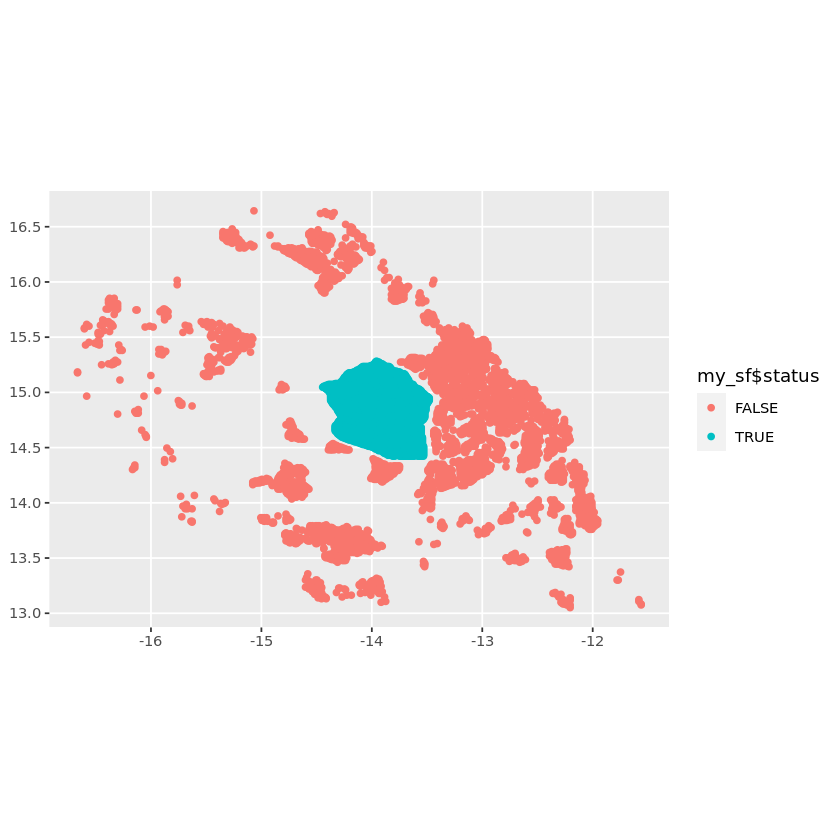

In [31]:
ggplot(my_sf) + 
   geom_sf(aes(color = my_sf$status))

In [295]:
 st_write(my_sf, "2332PA.shp", crs = 4326)

writing: substituting ENGCRS["Undefined Cartesian SRS with unknown unit"] for missing CRS



Writing layer `2332PA' to data source `2332PA.shp' using driver `ESRI Shapefile'
Writing 12806 features with 19 fields and geometry type Point.


In [293]:
getwd()

[1] "/projects/GEDI_PA/MAAP_GEDIAnalysis"